<a href="https://colab.research.google.com/github/anjali88/Data-Science/blob/master/MA_ARMA_ARIMA_FBProphet_HFT_close_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!python3 -m pip install fbprophet

The directory '/home/ubuntu/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/ubuntu/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
    100% |████████████████████████████████| 51kB 139kB/s ta 0:00:011
    100% |████████████████████████████████| 2.1MB 833kB/s eta 0:00:01
    100% |████████████████████████████████| 67.3MB 27kB/s eta 0:00:011   13% |████▏                           | 8.8MB 578kB/s eta 0:01:42    91% |█████████████████████████████▏  | 61.2MB 5.2MB/s eta 0:00:02
    100% |████████████████████████████████| 112kB 185kB/s ta 0:00:01
    100% |████████████████████████████████| 737kB 2.3MB/s eta 0:00:01
  Running setup.py ins

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Analysis imports
from pandas.plotting import lag_plot
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame
from pandas import concat

# Modelling imports
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA

# Prophet follows the sklearn model API. We create an instance of the Prophet class and then call its fit and predict methods.
# The input to Prophet is always a dataframe with two columns: ds and y. 
# The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. 
# The y column must be numeric, and represents the measurement we wish to forecast.

#from fbprophet import Prophet

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout

Using TensorFlow backend.
/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python

In [2]:
from google.colab import files
uploaded = files.upload()

Saving data_second.xlsx to data_second.xlsx


In [9]:
#dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
import io
file_name= '/home/ubuntu/hanan/HighFrequencyTrading/data_new.xlsx'
sheets= pd.ExcelFile(file_name).sheet_names
new_data  = pd.DataFrame()
for sheet in sheets:
    new_data[sheet]=pd.read_excel(file_name, sheet_name=sheet)['Close']
data = pd.read_excel(file_name, index_col="Dates",parse_dates=True,sheet_name=sheets[0])
# if we want to know what sort of detail is provided with this dataset, we can call .keys()
data.keys()

Index(['Open', 'Close', 'High', 'Low', 'Value', 'Volume'], dtype='object')

In [10]:
new_data.head()

,Anglo American plc,BP,CONSTRUCTION&Materials,EVRAZ Imdustrial Metals&Min,Oil&Gas Producer RDS CLASS A,Oil&Gas producer Class B
0,1679.8,476.25,2479,366.4,2295.5,2315.5
1,1680.8,475.00,2478,365.9,2293.5,2314.0
2,1679.0,474.90,2481,366.5,2286.5,2306.0
3,1675.6,476.30,2477,365.8,2286.0,2306.5
4,1676.4,475.15,2478,365.6,2287.5,2309.0


In [11]:
data[['Close', 'Open']].head(5)

,Close,Open
Dates,,
2018-02-14 08:00:00,1679.8,1682.0
2018-02-14 08:01:00,1680.8,1679.8
2018-02-14 08:02:00,1679.0,1681.2
2018-02-14 08:03:00,1675.6,1679.0
2018-02-14 08:04:00,1676.4,1674.6


In [12]:
print(sheets)

['Anglo American plc', 'BP', 'CONSTRUCTION&Materials', 'EVRAZ Imdustrial Metals&Min', 'Oil&Gas Producer RDS CLASS A', 'Oil&Gas producer Class B']


In [13]:
print('There are {} number of records  in the dataset.'.format(data.shape[0]))


There are 50 number of records  in the dataset.


/home/ubuntu/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


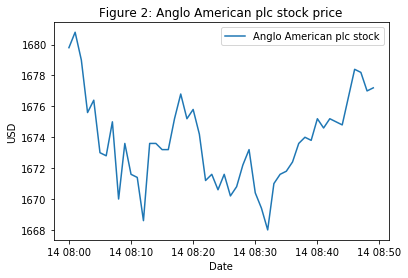

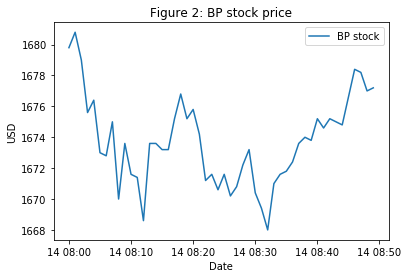

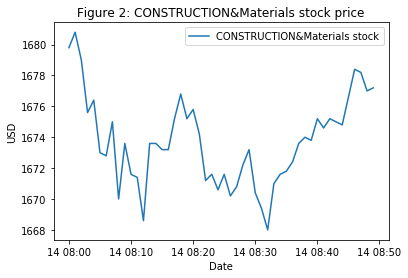

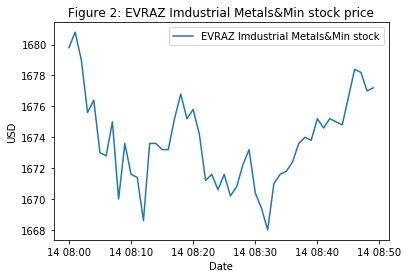

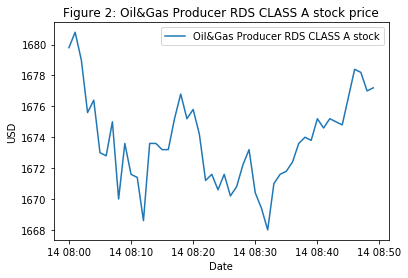

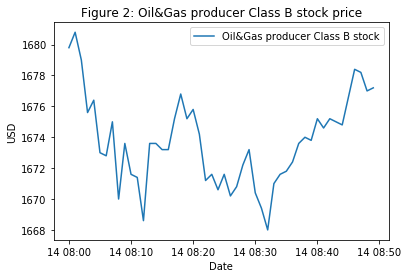

In [14]:
# Let's visualize the stock for the 7 months. The dashed vertical line represents the separation between training and test data.
plt.plot(data['Close'], label='{} stock'.format(sheets[0]))
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: {} stock price'.format(sheets[0]))
plt.legend()
plt.show()

plt.plot(data['Close'], label='{} stock'.format(sheets[1]))
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: {} stock price'.format(sheets[1]))
plt.legend()
plt.show()

plt.plot(data['Close'], label='{} stock'.format(sheets[2]))
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: {} stock price'.format(sheets[2]))
plt.legend()
plt.show()

plt.plot(data['Close'], label='{} stock'.format(sheets[3]))
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: {} stock price'.format(sheets[3]))
plt.legend()
plt.show()

plt.plot(data['Close'], label='{} stock'.format(sheets[4]))
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: {} stock price'.format(sheets[4]))
plt.legend()
plt.show()

plt.plot(data['Close'], label='{} stock'.format(sheets[5]))
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: {} stock price'.format(sheets[5]))
plt.legend()
plt.show()


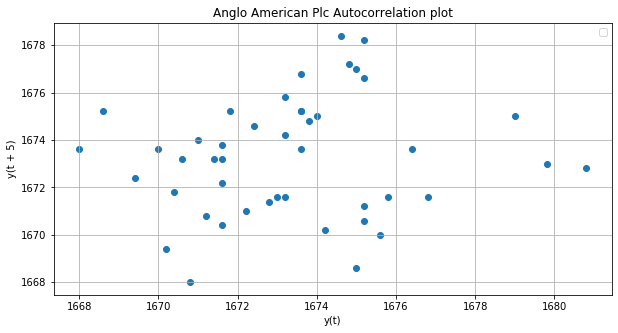

In [15]:
# Data Analysis

#Autocorrelation plot
plt.figure(figsize=(10,5))
lag_plot(data['Close'], lag=5)
plt.title('Anglo American Plc Autocorrelation plot')
plt.grid(True)
plt.legend();



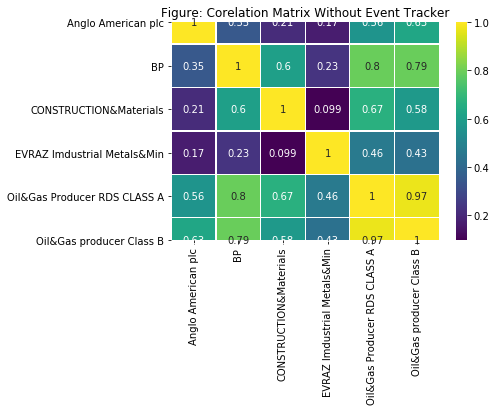

In [19]:
import seaborn as sns
cor=new_data.corr(method='pearson')
#cor=cor.drop(columns=input_company)
#cor=cor.drop(out_comp)

plt.title("Figure: Corelation Matrix Without Event Tracker")
cm=plt.cm.viridis
svm = sns.heatmap(cor,cmap=cm,linewidths=0.1,linecolor='white',annot=True)
plt.show()
#plt.savefig('graphs/correlation_matrix_without_event_tracker.png')
#plt.close()

<Figure size 1152x576 with 0 Axes>

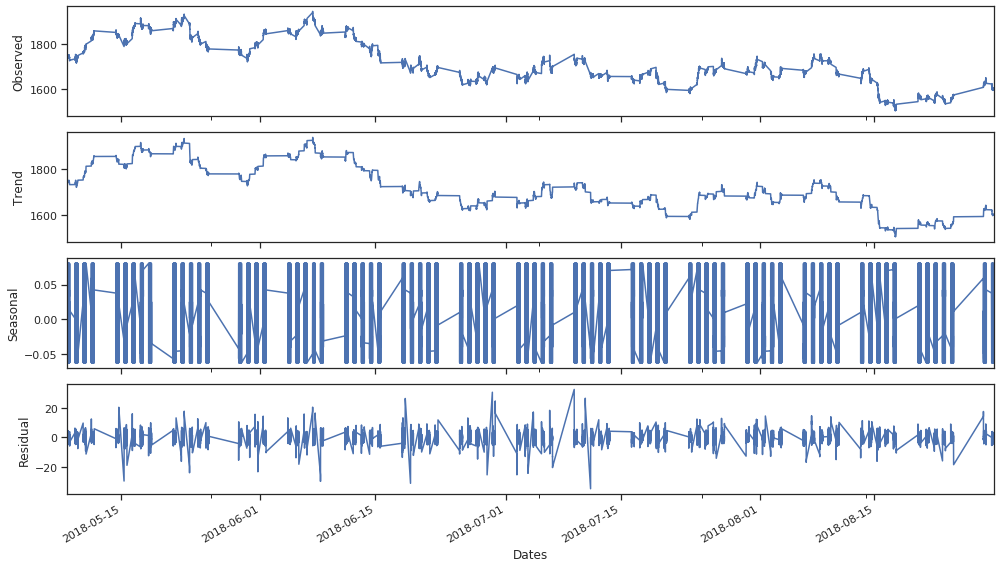

             t       t+1       t+5      t+10      t+30
t     1.000000  0.999174  0.998152  0.994080  0.999792
t+1   0.999174  1.000000  0.998967  0.994886  0.998967
t+5   0.998152  0.998967  1.000000  0.995889  0.997951
t+10  0.994080  0.994886  0.995889  1.000000  0.993879
t+30  0.999792  0.998967  0.997951  0.993879  1.000000


In [0]:
#Seasonal decompose

rcParams['figure.figsize'] = 14, 8
data_arima = data['Close']
result = seasonal_decompose(data_arima[-40000:], model='additive', freq=30)
plt.figure(figsize=(16,8))
fig = result.plot()
plt.show()

values = DataFrame(data['Close'].values)
dataframe = concat([values.shift(1),values.shift(5),values.shift(10),values.shift(30), values], axis=1)
dataframe.columns = ['t', 't+1', 't+5', 't+10', 't+30']
result = dataframe.corr()
print(result)


MSE: 9533.055313937599
MAE: 80.28706310469106
RMSE: 97.63736638161437


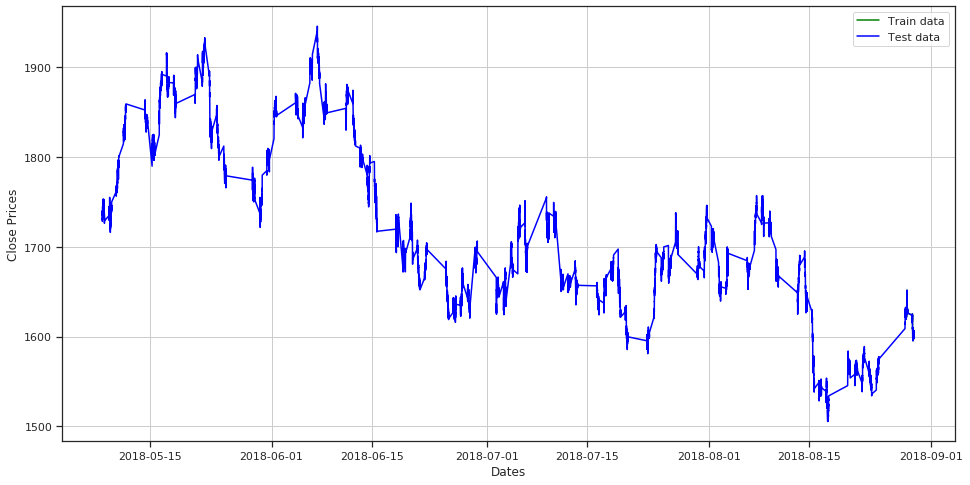

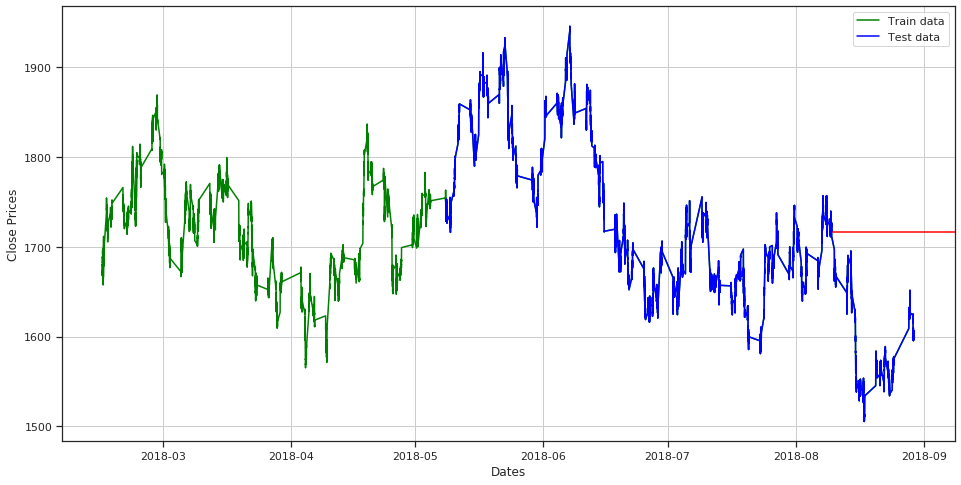

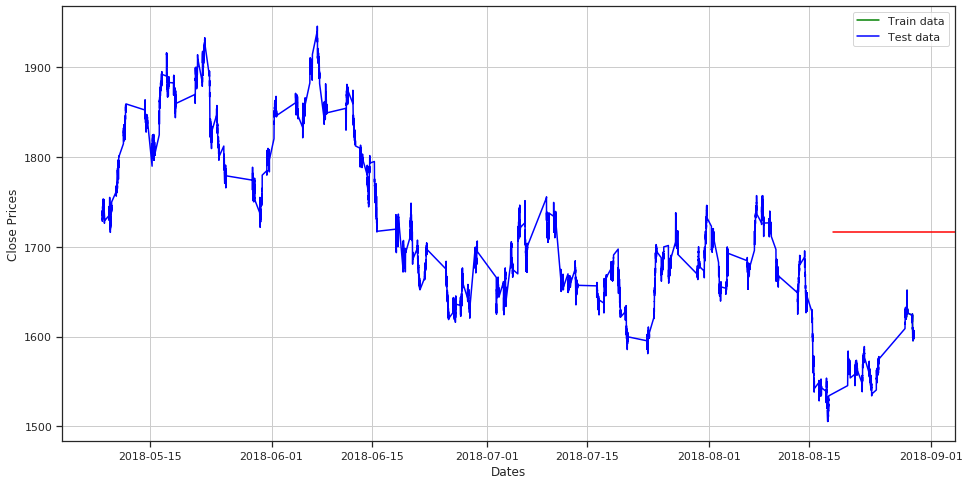

In [0]:
# Train-Test Split
train_data, test_data = data[0:-40000], data[-40000:]
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(data['Close'].tail(600), 'green', label='Train data')
plt.plot(test_data['Close'], 'blue', label='Test data')
plt.legend()

# Mean value plot
mean_value = data['Close'].mean() # calculation of mean price

plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(data['Close'], 'green', label='Train data')
plt.plot(test_data['Close'], 'blue', label='Test data')
plt.axhline(y=mean_value, xmin=0.864, xmax=1, color='red')
plt.legend()

plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(data['Close'].tail(600), 'green', label='Train data')
plt.plot(test_data['Close'], 'blue', label='Test data')
plt.axhline(y=mean_value, xmin=0.864, xmax=1, color='red')
plt.legend()

print('MSE: '+str(mean_squared_error(test_data['Close'], np.full(len(test_data), mean_value))))
print('MAE: '+str(mean_absolute_error(test_data['Close'], np.full(len(test_data), mean_value))))
print('RMSE: '+str(sqrt(mean_squared_error(test_data['Close'], np.full(len(test_data), mean_value)))))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Lag: 49
MSE: 2.8604096489419852
MAE: 1.0493090094755688
RMSE: 1.6912745634408344


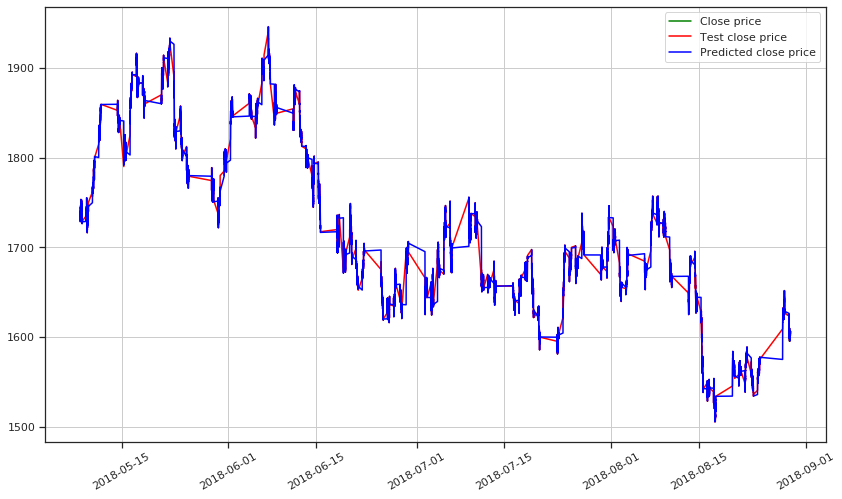

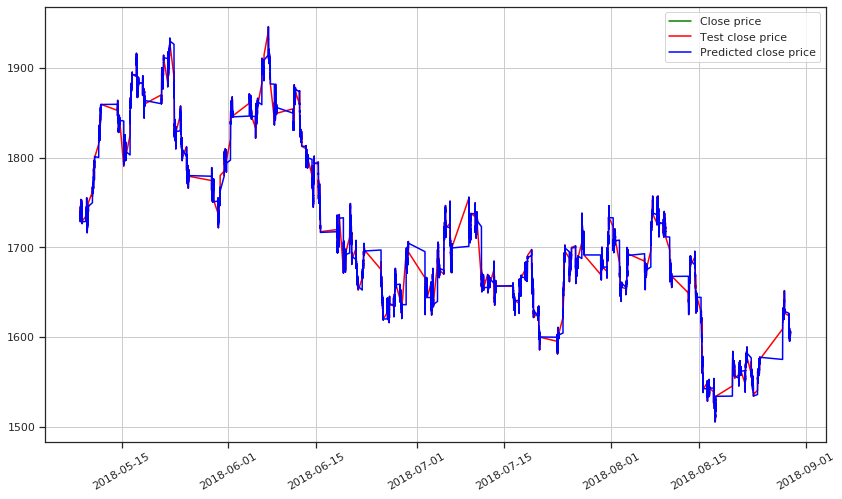

In [0]:
# Autoregression model
train_ar = train_data['Close']
test_ar = test_data['Close']

model = AR(train_ar)# train autoregression
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

# walk forward over time steps in test
history = train_ar[len(train_ar)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test_ar)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test_ar[t]
    predictions.append(yhat)
    history.append(obs)
 
plt.figure(figsize=(14,8))
plt.plot(data.index[-600:], data['Close'].tail(600), color='green', label='Close price')
plt.plot(test_data.index, test_data['Close'], color='red', label='Test close price')
plt.plot(test_data.index, predictions, color='blue', label='Predicted close price')
plt.xticks(rotation=30)
plt.grid(True)
plt.legend()

plt.figure(figsize=(14,8))
print('Lag: %s' % model_fit.k_ar)
plt.plot(data.index[-100:], data['Close'].tail(100), color='green', label='Close price')
plt.plot(test_data.index, test_data['Close'], color='red', label='Test close price')
plt.plot(test_data.index, predictions, color='blue', label='Predicted close price')
plt.xticks(rotation=30)
plt.grid(True)
plt.legend()

print('MSE: '+str(mean_squared_error(test_data['Close'], predictions)))
print('MAE: '+str(mean_absolute_error(test_data['Close'], predictions)))
print('RMSE: '+str(sqrt(mean_squared_error(test_data['Close'], predictions))))

In [0]:
# Moving Average model
train_ma = train_data['Close']
test_ma = test_data['Close']

history = [x for x in train_ma]
y = test_ma
# make first prediction
predictions = list()
model = ARMA(history, order=(0,8))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast()[0]
predictions.append(yhat)

history.append(y[0])
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARMA(history, order=(0,8))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)

plt.figure(figsize=(14,8))
plt.plot(data.index[-600:], data['Close'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()
print('MSE: '+str(mean_squared_error(y, predictions)))
print('MAE: '+str(mean_absolute_error(y, predictions)))
print('RMSE: '+str(sqrt(mean_squared_error(y, predictions))))

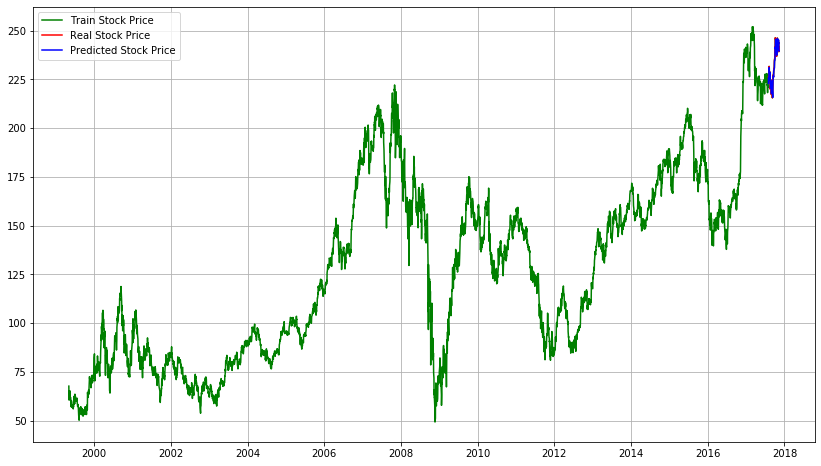

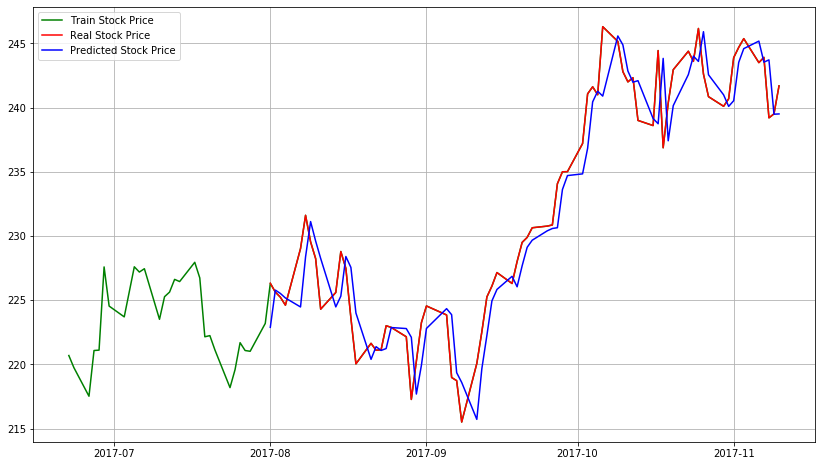

MSE: 6.677045320364875
MAE: 2.016518003129875
RMSE: 2.583997933506309


In [0]:
# ARMA model
train_arma = train_data['Open']
test_arma = test_data['Open']

history = [x for x in train_arma]
y = test_arma
# make first prediction
predictions = list()
model = ARMA(history, order=(1,8))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast()[0]
predictions.append(yhat)

history.append(y[0])
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARMA(history, order=(1,8))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
plt.figure(figsize=(14,8))
plt.plot(data.index, data['Open'], color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14,8))
plt.plot(data.index[-100:], data['Open'].tail(100), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()
print('MSE: '+str(mean_squared_error(y, predictions)))
print('MAE: '+str(mean_absolute_error(y, predictions)))
print('RMSE: '+str(sqrt(mean_squared_error(y, predictions))))

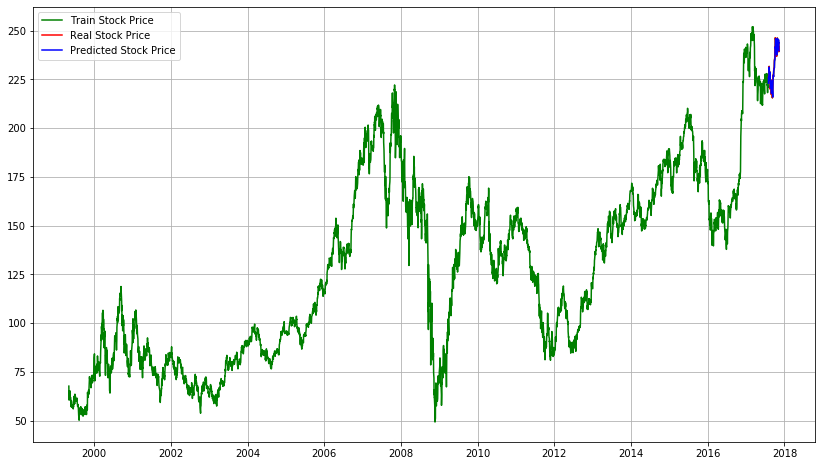

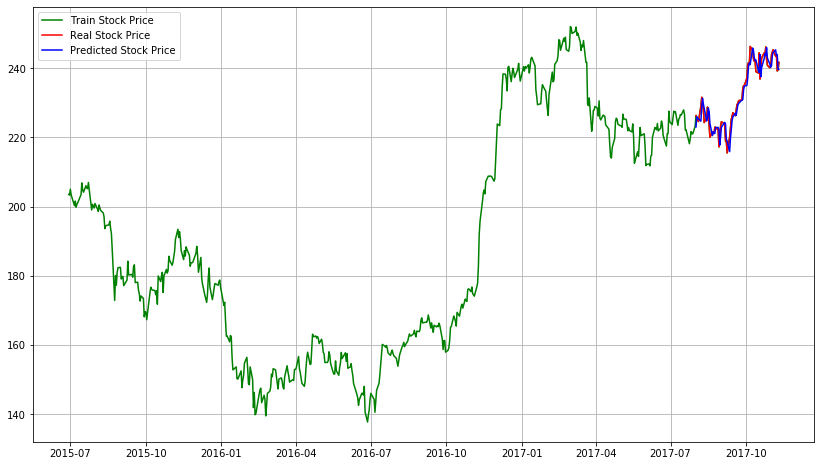

MSE: 6.585688141513062
MAE: 2.004152038329677
RMSE: 2.566259562381222


In [0]:
# ARIMA model
train_arima = train_data['Open']
test_arima = test_data['Open']

history = [x for x in train_arima]
y = test_arima
# make first prediction
predictions = list()
model = ARIMA(history, order=(1,1,0))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])
# rolling forecasts
for i in range(1, len(y)):
  # predict
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    
plt.figure(figsize=(14,8))
plt.plot(data.index, data['Open'], color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(14,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()

print('MSE: '+str(mean_squared_error(y, predictions)))
print('MAE: '+str(mean_absolute_error(y, predictions)))
print('RMSE: '+str(sqrt(mean_squared_error(y, predictions))))

In [0]:
# Facebook Prophet

# Drop the columns
ph_df_train = train_data.drop(['Close', 'High', 'Low','Volume', 'OpenInt'], axis=1)
ph_df_train['Date'] = ph_df_train.index
ph_df_train.rename(columns={'Open': 'y', 'Date': 'ds'}, inplace=True)

prop = Prophet(changepoint_prior_scale=0.1)
prop.fit(ph_df_train)
# Create Future dates
future_prices = prop.make_future_dataframe(periods=73)

# Predict Prices
forecast = prop.predict(future_prices)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


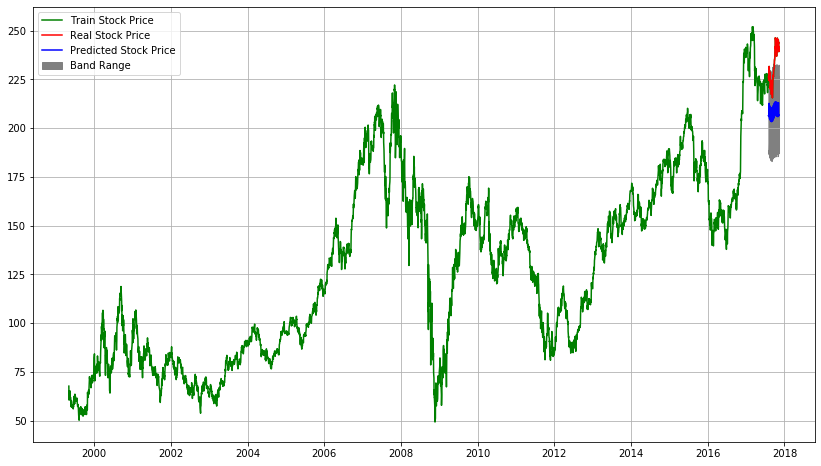

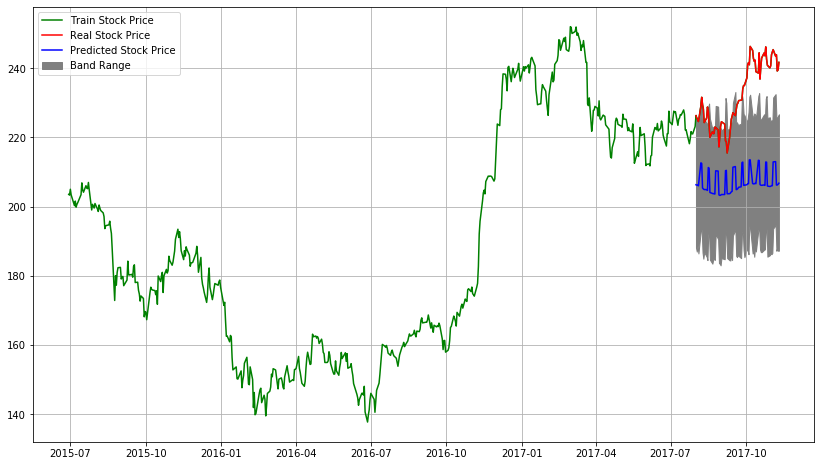

MSE: 699.5725694538435
MAE: 25.058554914045025
RMSE: 26.449434199125008


In [0]:
plt.figure(figsize=(14,8))
plt.plot(data.index, data['Open'], color='green', label = 'Train Stock Price')
plt.plot(test_data.index, test_data['Open'], color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, forecast['yhat'][-73:], color = 'blue', label = 'Predicted Stock Price')
plt.fill_between(test_data.index, forecast['yhat_lower'][-73:], forecast['yhat_upper'][-73:], color='grey', label="Band Range")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, test_data['Open'], color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, forecast['yhat'][-73:], color = 'blue', label = 'Predicted Stock Price')
plt.fill_between(test_data.index, forecast['yhat_lower'][-73:], forecast['yhat_upper'][-73:], color='grey', label="Band Range")
plt.legend()
plt.grid(True)
plt.show()

print('MSE: '+str(mean_squared_error(test_data['Open'], forecast['yhat'][-73:])))
print('MAE: '+str(mean_absolute_error(test_data['Open'], forecast['yhat'][-73:])))
print('RMSE: '+str(sqrt(mean_squared_error(test_data['Open'], forecast['yhat'][-73:]))))

In [0]:
# LSTM

train = train_data.iloc[:, 0:1].values # selecting open prices
# Feature Scaling
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train) 
# Train dataset
timesteps = 7
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0]) # we take 30 previous prices
    y_train.append(train_scaled[i, 0]) # and 60-th price as y value
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
from numpy.random import seed
seed(2019)

In [0]:
model = Sequential()

# Adding the first LSTM layer 
# Here return_sequences=True means whether to return the last output in the output sequence, or the full sequence.
# it basically tells us that there is another(or more) LSTM layer ahead in the network.
model.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Dropout regularisation for tackling overfitting
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
# RMSprop is a recommended optimizer as per keras documentation
# check out https://keras.io/optimizers/ for more details
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 65, batch_size = 16)

Epoch 1/65
68087/68087 [==============================] - 57s 835us/step - loss: 0.0017
Epoch 2/65
68087/68087 [==============================] - 54s 789us/step - loss: 4.0111e-04
Epoch 3/65
68087/68087 [==============================] - 54s 796us/step - loss: 3.7885e-04
Epoch 4/65
68087/68087 [==============================] - 55s 810us/step - loss: 3.7450e-04
Epoch 5/65
68087/68087 [==============================] - 56s 818us/step - loss: 3.6339e-04
Epoch 6/65
68087/68087 [==============================] - 56s 823us/step - loss: 3.5389e-04
Epoch 7/65
68087/68087 [==============================] - 56s 821us/step - loss: 3.6240e-04
Epoch 8/65
68087/68087 [==============================] - 56s 815us/step - loss: 3.5236e-04
Epoch 9/65
68087/68087 [==============================] - 55s 808us/step - loss: 3.4586e-04
Epoch 10/65
68087/68087 [==============================] - 57s 834us/step - loss: 3.3999e-04
Epoch 11/65
68087/68087 [==============================] - 57s 839us/step - loss: 3

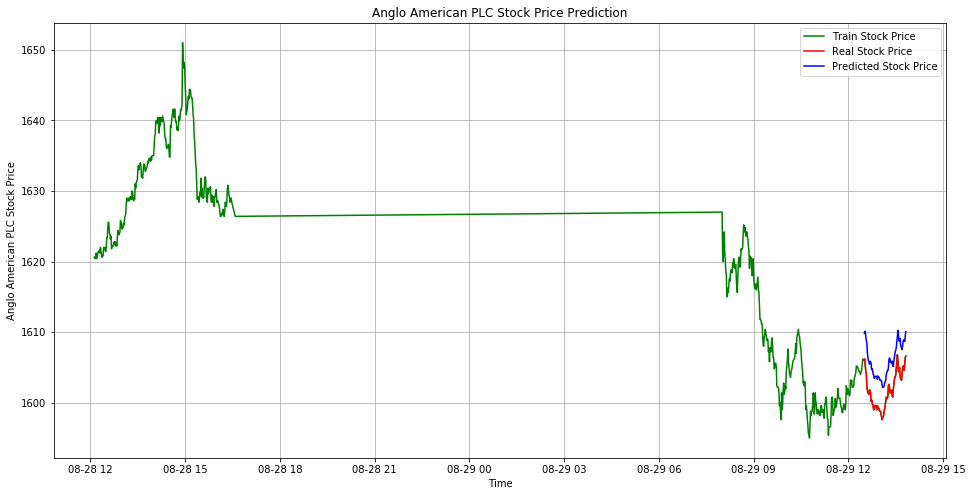

MSE: 17.496737729376253
MAE: 4.118969392123284
RMSE: 4.182910198579005


In [0]:
# this will be used later while comparing and visualization
real_stock_price = test_data.iloc[:,0:1].values # taking open price
# combine original train and test data vertically
# as previous Open Prices are not present in test dataset
# e.g. for predicting Open price for first date in test data, we will need stock open prices on timesteps previous dates  
combine = pd.concat((train_data['Open'], test_data['Open']), axis = 0)
# our test inputs also contains stock open Prices of last timesteps dates (as described above)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)
# same steps as we followed while processing training data
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
# inverse_transform because prediction is done on scaled inputs
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Anglo American PLC Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Anglo American PLC Stock Price')
plt.legend()
plt.grid(True)
plt.savefig('lstm_30.pdf')
plt.show()

mse = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae))
rmse = sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse))